In [1]:
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar
import xarray as xr
from pathlib import Path
import cmocean
import pandas as pd
import geopandas as gpd
import harmonica as hm
import verde as vd

import sys
sys.path.append("..")

from stochastic_bathymetry.utilities import xy_into_grid, get_topo_cm
from stochastic_bathymetry.prisms import make_prisms

In [2]:
bm = xr.open_dataset(Path('G:/stochastic_bathymetry/processed_data/xr_2000.nc'))

xmin = np.min(bm.x.values)
xmax = np.max(bm.x.values)
ymin = np.min(bm.y.values)
ymax = np.max(bm.y.values)

In [3]:
# MOA: https://nsidc.org/data/nsidc-0730/versions/1
moa_base = Path('G:/stochastic_bathymetry/raw_data/nsidc0730_MEASURES_MOA2014_v01')

# moa coast and grounding line
moa_coast = gpd.read_file(moa_base/'coastlines/moa2014_coastline_v01.shp')
moa_gl = gpd.read_file(moa_base/'coastlines/moa2014_grounding_line_v01.shp')
moa_island = gpd.read_file(moa_base/'coastlines/moa2014_islands_v01.shp')

glkm = moa_gl.to_crs('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +type=crs')
coastkm = moa_coast.to_crs('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +type=crs')
islandkm = moa_island.to_crs('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +type=crs')

# Gravity gradients

In [4]:
grav = pd.read_csv(Path('G:/stochastic_bathymetry/processed_data/grav_leveled_2000.csv'))
grav.head()

x         y        faa  height    msk  inv_msk  inv_pad  boug_mean  \
0 -1597500.0 -703500.0  13.426661    1200  False      0.0     True  24.858213   
1 -1595500.0 -703500.0  17.633585    1200  False      0.0     True  17.895150   
2 -1593500.0 -703500.0  20.908302    1200  False      0.0     True  13.669522   
3 -1591500.0 -703500.0  22.584675    1200  False      0.0     True  11.194253   
4 -1589500.0 -703500.0  23.212216    1200  False      0.0    False   8.725158   

       boug_std    te_mean  
0  2.131628e-14 -11.431551  
1  2.131628e-14  -0.261565  
2  2.309264e-14   7.238780  
3  8.881784e-15  11.390423  
4  8.881784e-15  14.487058

In [5]:
grav_grid = xy_into_grid(bm, (grav.x.values, grav.y.values), grav.faa.values)
grav_grid = np.array(grav_grid)

In [6]:
density_dict = {
    'ice' : 917,
    'water' : 1027,
    'rock' : 2670
}

prisms, densities = make_prisms(bm, bm.bed.values, density_dict)
pred_coords = (grav.x, grav.y, grav.height)
g_z = hm.prism_gravity(pred_coords, prisms, densities, field='g_z')
residual = grav.faa-g_z

In [7]:
g_z_grid, residual_grid = xy_into_grid(bm, (grav.x.values, grav.y.values), (g_z, residual))

In [8]:
xx, yy = np.meshgrid(bm.x, bm.y)

grav_msk = ~np.isnan(grav_grid)

nearest = vd.KNeighbors(k=10)
nearest.fit(
    coordinates=(grav.x.values, grav.y.values),
    data = grav.faa.values
)
faa_fill = nearest.predict((xx.flatten(), yy.flatten()))
faa_fill = np.where(grav_msk==True, grav_grid, faa_fill.reshape(xx.shape))

In [9]:
ygrad, xgrad = np.gradient(faa_fill, 2000)

In [10]:
xgrad = np.where(np.isnan(grav_grid), np.nan, xgrad)
ygrad = np.where(np.isnan(grav_grid), np.nan, ygrad)

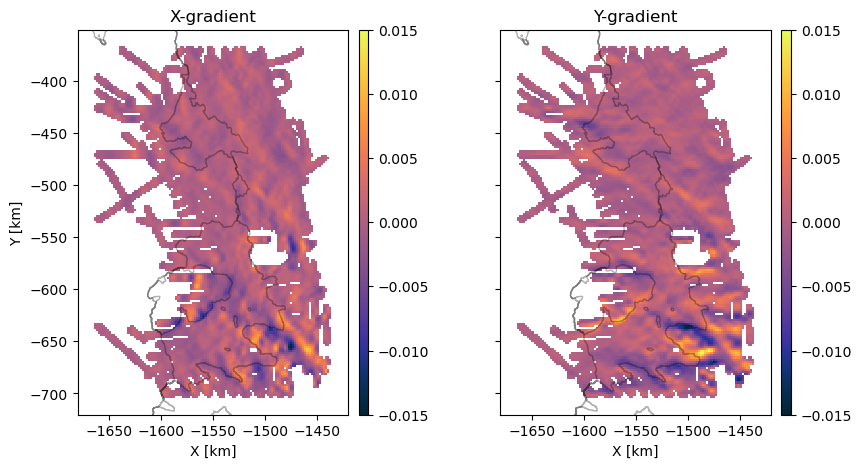

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax = axs[0]
im = ax.pcolormesh(bm.x/1000, bm.y/1000, xgrad, vmin=-0.015, vmax=0.015, cmap='cmo.thermal')
ax.axis('scaled')
ax.set_title('X-gradient')
ax.set_ylabel('Y [km]')
ax.set_xlabel('X [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
ax = axs[1]
im = ax.pcolormesh(bm.x/1000, bm.y/1000, ygrad, vmin=-0.015, vmax=0.015, cmap='cmo.thermal')
ax.axis('scaled')
ax.set_title('Y-gradient')
ax.set_xlabel('X [km]')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

for ax in axs:
    glkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=1, alpha=0.3)
    coastkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=1, alpha=0.3)
    islandkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=1, alpha=0.3)
plt.savefig('grav_gradients.png', dpi=300, bbox_inches='tight')
plt.show()

# ADMAP2B

In [12]:
ds = xr.open_dataset(Path('D:/Eagles-etal_2024_ADMAP_allfiles/ADMAP_2B_2017_epsg3031_gdal_SF0.9725.nc'))
ds

<xarray.Dataset> Size: 82MB
Dimensions:       (x: 4533, y: 4534, grid_mapping: 12)
Coordinates:
  * x             (x) float64 36kB -3.398e+06 -3.397e+06 ... 3.4e+06 3.401e+06
  * y             (y) float64 36kB -3.4e+06 -3.398e+06 ... 3.4e+06 3.401e+06
  * grid_mapping  (grid_mapping) |S1 12B b'a' b'd' b'd' ... b't' b'' b'\x99'
Data variables:
    z             (y, x) float32 82MB ...
Attributes:
    Conventions:  COARDS, CF-1.5
    title:        Produced by grdconvert
    history:      grdconvert ADMAP_2B_2017_epsg3031_gdal_SF0.9725.tif -GADMAP...
    description:  
    GMT_version:  5.4.5 [64-bit]
    node_offset:  1

In [13]:
ds.x.values[1]-ds.x.values[0]

np.float64(1500.4149299110286)

In [14]:
np.unique(np.diff(ds.x.values))

array([1500.41492991, 1500.41492991, 1500.41492991, 1500.41492991,
       1500.41492991])

In [15]:
xminkm = xmin/1000
xmaxkm = xmax/1000
yminkm = ymin/1000
ymaxkm = ymax/1000

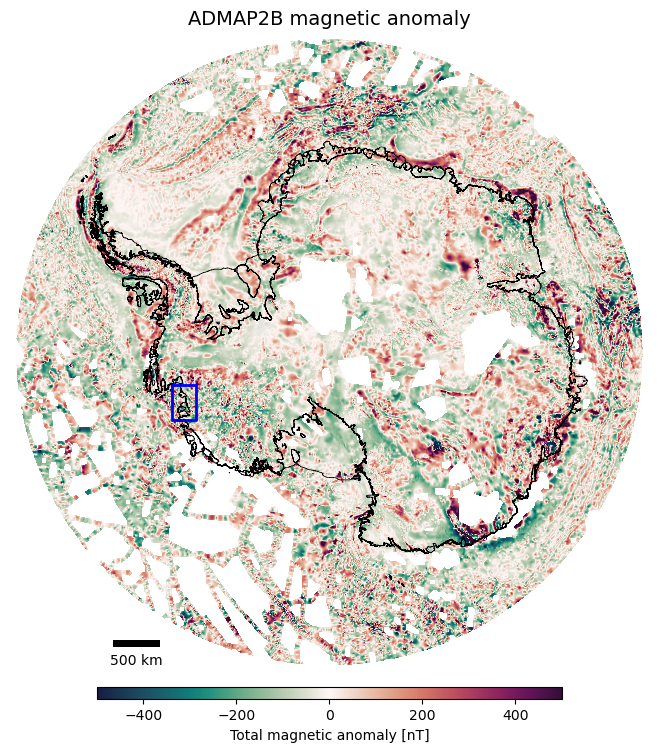

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
im = ax.pcolormesh(ds.x/1000, ds.y/1000, ds.z, vmin=-500, vmax=500, cmap='cmo.curl')
ax.axis('scaled')

glkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)
coastkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)
islandkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)

ax.set_title('ADMAP2B magnetic anomaly', fontsize=14)

cbar = plt.colorbar(im, ax=ax, pad=0.02, aspect=40, shrink=0.5, orientation='horizontal', location='bottom')
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='Total magnetic anomaly [nT]', fontsize=10)

scalebar = ScaleBar(1, "km", length_fraction=0.1, location='lower left', bbox_to_anchor=(0.15, 0.00),
    bbox_transform=ax.transAxes)
ax.add_artist(scalebar)

rect = Rectangle((xminkm, yminkm), xmaxkm-xminkm, ymaxkm-yminkm)
collection = PatchCollection([rect], edgecolor='b', facecolor='none', linewidth=2)
ax.add_collection(collection)

ax.set_axis_off()
plt.savefig('admap2b.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
ds_trim = ds.sel(x=slice(xmin, xmax), y=slice(ymin, ymax))
ds_trim

<xarray.Dataset> Size: 172kB
Dimensions:       (x: 172, y: 245, grid_mapping: 12)
Coordinates:
  * x             (x) float64 1kB -1.679e+06 -1.677e+06 ... -1.422e+06
  * y             (y) float64 2kB -7.187e+05 -7.172e+05 ... -3.526e+05
  * grid_mapping  (grid_mapping) |S1 12B b'a' b'd' b'd' ... b't' b'' b'\x99'
Data variables:
    z             (y, x) float32 169kB -88.28 -69.17 -52.01 ... 173.0 189.3
Attributes:
    Conventions:  COARDS, CF-1.5
    title:        Produced by grdconvert
    history:      grdconvert ADMAP_2B_2017_epsg3031_gdal_SF0.9725.tif -GADMAP...
    description:  
    GMT_version:  5.4.5 [64-bit]
    node_offset:  1

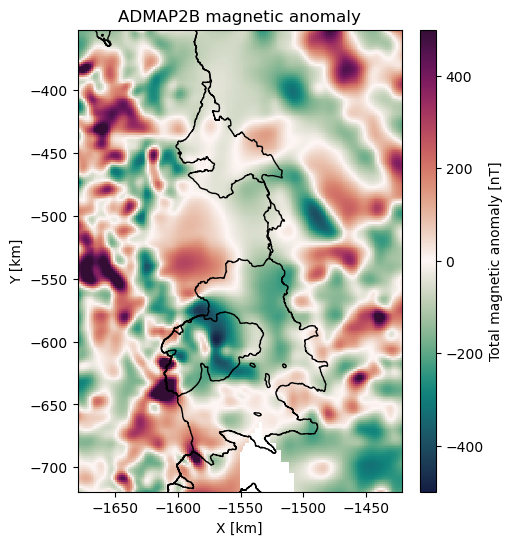

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
im = ax.pcolormesh(ds_trim.x/1000, ds_trim.y/1000, ds_trim.z, vmin=-500, vmax=500, cmap='cmo.curl')
ax.axis('scaled')

glkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=1)
coastkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=1)
islandkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=1)

ax.set_title('ADMAP2B magnetic anomaly')
ax.set_ylabel('Y [km]')
ax.set_xlabel('X [km]')

plt.colorbar(im, ax=ax, pad=0.04, aspect=30, label='Total magnetic anomaly [nT]')
plt.savefig('admap2b_local.png', dpi=300, bbox_inches='tight')
plt.show()

# ADMAP2S

In [19]:
ds2 = xr.open_dataset(Path('D:/Eagles-etal_2024_ADMAP_allfiles/ADMAP_2S_epsg3031_gdal.nc'))
ds2

<xarray.Dataset> Size: 7MB
Dimensions:              (x: 1334, y: 1334)
Coordinates:
  * x                    (x) float64 11kB -3.333e+06 -3.328e+06 ... 3.332e+06
  * y                    (y) float64 11kB -3.332e+06 -3.327e+06 ... 3.333e+06
Data variables:
    polar_stereographic  |S1 1B ...
    z                    (y, x) float32 7MB ...
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         COARDS, CF-1.5
    GMT_version:         5.4.5 [64-bit]
    history:             Tue Feb 13 09:30:23 2024: GDAL CreateCopy( ADMAP_2S_...
    title:               Data gridded with continuous surface splines in tension
    GDAL:                GDAL 3.8.3, released 2024/01/04

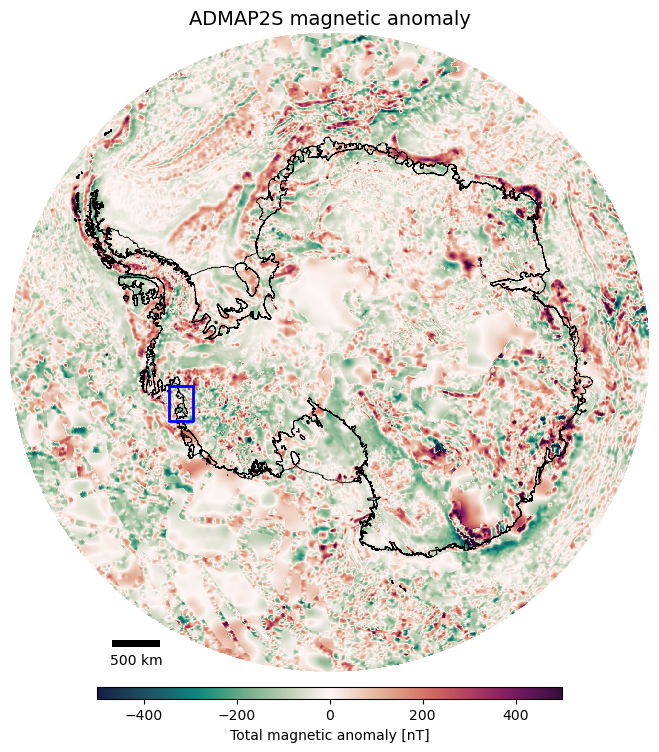

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
im = ax.pcolormesh(ds2.x/1000, ds2.y/1000, ds2.z, vmin=-500, vmax=500, cmap='cmo.curl')
ax.axis('scaled')

glkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)
coastkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)
islandkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)

ax.set_title('ADMAP2S magnetic anomaly', fontsize=14)

cbar = plt.colorbar(im, ax=ax, pad=0.02, aspect=40, shrink=0.5, orientation='horizontal', location='bottom')
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='Total magnetic anomaly [nT]', fontsize=10)

scalebar = ScaleBar(1, "km", length_fraction=0.1, location='lower left', bbox_to_anchor=(0.15, 0.00),
    bbox_transform=ax.transAxes)
ax.add_artist(scalebar)

rect = Rectangle((xminkm, yminkm), xmaxkm-xminkm, ymaxkm-yminkm)
collection = PatchCollection([rect], edgecolor='b', facecolor='none', linewidth=2)
ax.add_collection(collection)

ax.set_axis_off()
plt.savefig('admap2s.png', dpi=300, bbox_inches='tight')
plt.show()

# AntGG

In [21]:
import os
das = []
for item in os.scandir(Path('D:/AntGG2021_allfiles')):
    if item.name.endswith('.nc'):
        print(item.name)
        da_tmp = xr.open_dataset(item.path)
        das.append(da_tmp)

AntGG2021_Bouguer-anomaly.nc
AntGG2021_Gravity-anomaly.nc
AntGG2021_Gravity-disturbance_5000m.nc
AntGG2021_Gravity_disturbance_at-surface.nc
AntGG2021_Height-anomaly_at-ellipsoid.nc
AntGG2021_Height_anomaly_at-surface.nc
AntGG2021_Second-radial-derivative-of-disturbing-potential.nc
AntGG2021_Standard-deviation_GA-from-LSC.nc


In [22]:
ant = xr.merge(das, compat='override')
ant

<xarray.Dataset> Size: 156MB
Dimensions:                    (x: 1333, y: 1333, map_projection: 0)
Coordinates:
  * x                          (x) float64 11kB -3.33e+06 ... 3.33e+06
  * y                          (y) float64 11kB -3.33e+06 ... 3.33e+06
  * map_projection             (map_projection) |S1 0B 
Data variables:
    Boug_anom                  (x, y) float64 14MB ...
    h_ell                      (x, y) float64 14MB ...
    grav_anom                  (x, y) float64 14MB ...
    gravity_disturbance_5000m  (x, y) float64 14MB ...
    ell_height                 (x, y) float64 14MB ...
    grav_dist                  (x, y) float64 14MB ...
    h_anomaly_ell              (x, y) float64 14MB ...
    height_anomaly_surf        (x, y) float64 14MB ...
    d2T_dr2                    (x, y) float64 14MB ...
    std_grav_anom              (x, y) float64 14MB ...
    h_ellips                   (x, y) float64 14MB ...

In [23]:
ant = xr.Dataset(
    data_vars = dict(
        Boug_anom = (['y', 'x'], ant.Boug_anom.values[::-1,:]),
        grav_dist = (['y', 'x'], ant.grav_dist.values[::-1,:]),
        gravity_disturbance_5000m = (['y', 'x'], ant.gravity_disturbance_5000m.values[::-1,:]),
    ),
    coords=dict(
        y=("y", ant.y.values[::-1]),
        x=("x", ant.x.values),
    )
)

ant

<xarray.Dataset> Size: 43MB
Dimensions:                    (y: 1333, x: 1333)
Coordinates:
  * y                          (y) float64 11kB 3.33e+06 3.325e+06 ... -3.33e+06
  * x                          (x) float64 11kB -3.33e+06 ... 3.33e+06
Data variables:
    Boug_anom                  (y, x) float64 14MB nan nan nan ... nan nan nan
    grav_dist                  (y, x) float64 14MB nan nan nan ... nan nan nan
    gravity_disturbance_5000m  (y, x) float64 14MB nan nan nan ... nan nan nan

In [24]:
ant.x.values[1]-ant.x.values[0]

np.float64(5000.0)

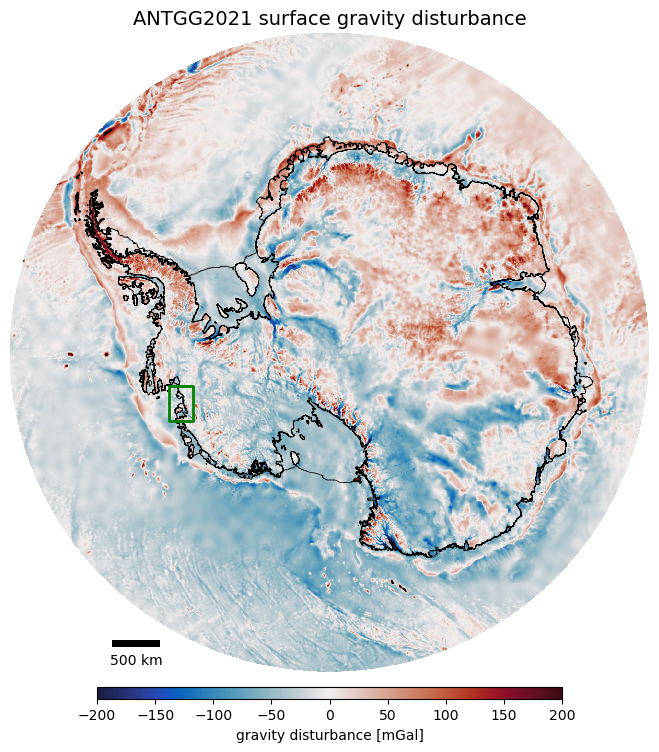

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
im = ax.pcolormesh(ant.x/1000, ant.y/1000, ant.grav_dist, vmin=-200, vmax=200, cmap='cmo.balance')
ax.axis('scaled')

glkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)
coastkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)
islandkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)

ax.set_title('ANTGG2021 surface gravity disturbance', fontsize=14)

cbar = plt.colorbar(im, ax=ax, pad=0.02, aspect=40, shrink=0.5, orientation='horizontal', location='bottom')
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='gravity disturbance [mGal]', fontsize=10)

scalebar = ScaleBar(1, "km", length_fraction=0.1, location='lower left', bbox_to_anchor=(0.15, 0.00),
    bbox_transform=ax.transAxes)
ax.add_artist(scalebar)

rect = Rectangle((xminkm, yminkm), xmaxkm-xminkm, ymaxkm-yminkm)
collection = PatchCollection([rect], edgecolor='g', facecolor='none', linewidth=2)
ax.add_collection(collection)

ax.set_axis_off()
plt.savefig('antgg2021.png', dpi=300, bbox_inches='tight')
plt.show()

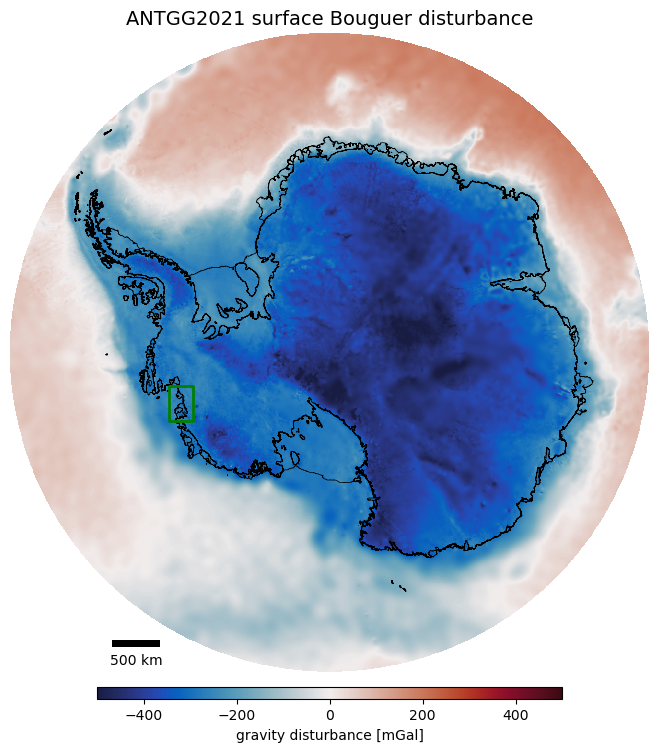

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
im = ax.pcolormesh(ant.x/1000, ant.y/1000, ant.Boug_anom, vmin=-500, vmax=500, cmap='cmo.balance')
ax.axis('scaled')

glkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)
coastkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)
islandkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)

ax.set_title('ANTGG2021 surface Bouguer disturbance', fontsize=14)

cbar = plt.colorbar(im, ax=ax, pad=0.02, aspect=40, shrink=0.5, orientation='horizontal', location='bottom')
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='gravity disturbance [mGal]', fontsize=10)

scalebar = ScaleBar(1, "km", length_fraction=0.1, location='lower left', bbox_to_anchor=(0.15, 0.00),
    bbox_transform=ax.transAxes)
ax.add_artist(scalebar)

rect = Rectangle((xminkm, yminkm), xmaxkm-xminkm, ymaxkm-yminkm)
collection = PatchCollection([rect], edgecolor='g', facecolor='none', linewidth=2)
ax.add_collection(collection)

ax.set_axis_off()
plt.show()

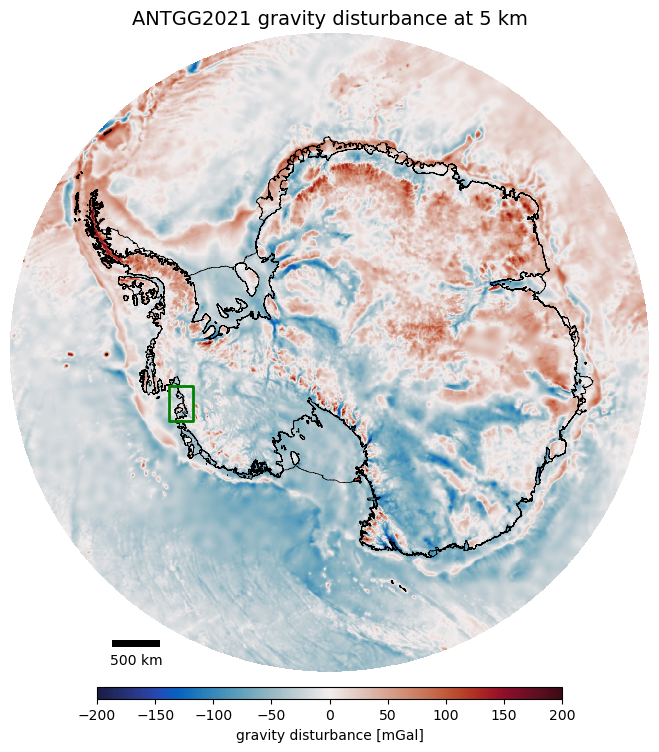

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
im = ax.pcolormesh(ant.x/1000, ant.y/1000, ant.gravity_disturbance_5000m, vmin=-200, vmax=200, cmap='cmo.balance')
ax.axis('scaled')

glkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)
coastkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)
islandkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)

ax.set_title('ANTGG2021 gravity disturbance at 5 km', fontsize=14)

cbar = plt.colorbar(im, ax=ax, pad=0.02, aspect=40, shrink=0.5, orientation='horizontal', location='bottom')
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='gravity disturbance [mGal]', fontsize=10)

scalebar = ScaleBar(1, "km", length_fraction=0.1, location='lower left', bbox_to_anchor=(0.15, 0.00),
    bbox_transform=ax.transAxes)
ax.add_artist(scalebar)

rect = Rectangle((xminkm, yminkm), xmaxkm-xminkm, ymaxkm-yminkm)
collection = PatchCollection([rect], edgecolor='g', facecolor='none', linewidth=2)
ax.add_collection(collection)

ax.set_axis_off()
plt.savefig('antgg2021_5000m.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
ant_trim = ant.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))
ant_trim

<xarray.Dataset> Size: 90kB
Dimensions:                    (y: 73, x: 51)
Coordinates:
  * y                          (y) float64 584B -3.55e+05 -3.6e+05 ... -7.15e+05
  * x                          (x) float64 408B -1.675e+06 ... -1.425e+06
Data variables:
    Boug_anom                  (y, x) float64 30kB -273.7 -283.0 ... -316.7
    grav_dist                  (y, x) float64 30kB -10.94 -16.09 ... 25.84 9.107
    gravity_disturbance_5000m  (y, x) float64 30kB -10.99 -13.32 ... 15.31 4.116

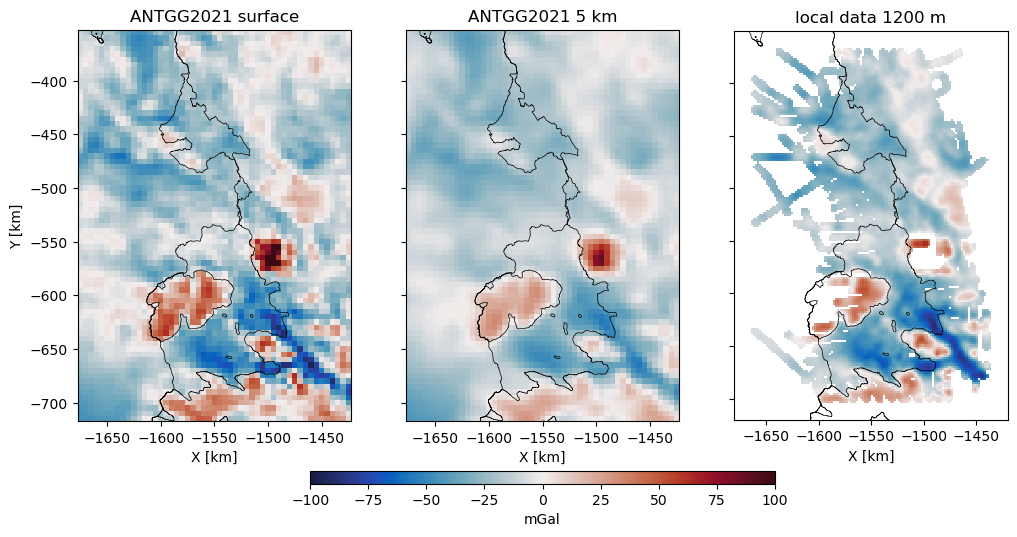

In [29]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(12,6))
gspec = GridSpec(2, 3, height_ratios=[1, 0.03])

#fig, axs = plt.subplots(1, 3, figsize=(12,5))
axs = []
for i in range(3):
    axs.append(fig.add_subplot(gspec[0,i]))

ax = axs[0]
im = ax.pcolormesh(ant_trim.x/1000, ant_trim.y/1000, ant_trim.grav_dist.values, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('ANTGG2021 surface')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')

ax = axs[1]
im = ax.pcolormesh(ant_trim.x/1000, ant_trim.y/1000, ant_trim.gravity_disturbance_5000m.values, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('ANTGG2021 5 km')
ax.set_xlabel('X [km]')
ax.set_yticklabels([])

ax = axs[2]
im = ax.pcolormesh(xx/1000, yy/1000, grav_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('local data 1200 m')
ax.set_xlabel('X [km]')
ax.set_yticklabels([])

gspec2 = GridSpecFromSubplotSpec(1, 100, gspec[1,:])
cax = fig.add_subplot(gspec2[25:75])
plt.colorbar(im, cax=cax, orientation='horizontal', label='mGal')

for ax in axs:
    glkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)
    coastkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)
    islandkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)

plt.savefig('antgg2021_local.png', dpi=300, bbox_inches='tight')
plt.show()

# BedMap3

In [30]:
bm3 = xr.open_dataset(Path('D:/bedmap3.nc'))
bm3

<xarray.Dataset> Size: 5GB
Dimensions:                 (x: 13334, y: 13334)
Coordinates:
  * x                       (x) float32 53kB -3.333e+06 -3.333e+06 ... 3.333e+06
  * y                       (y) float32 53kB 3.333e+06 3.333e+06 ... -3.333e+06
Data variables:
    surface_topography      (y, x) float32 711MB ...
    bed_uncertainty         (y, x) float32 711MB ...
    bed_topography          (y, x) float32 711MB ...
    mask                    (y, x) float32 711MB ...
    ice_thickness           (y, x) float32 711MB ...
    thickness_survey_count  (y, x) float32 711MB ...
    thickness_uncertainty   (y, x) float32 711MB ...
    mapping                 <U19 76B ...
Attributes: (12/26)
    crs:                    EPSG:3031
    title:                  BEDMAP3 - Ice thickness, bed and surface elevatio...
    summary:                We present here Bedmap3, the latest suite of grid...
    keywords:               Antarctica,BEDMAP,Elevation,Ice thickness
    Conventions:            ACDD-1.3, CF-1.8
    citation:               Pritchard, H., Fretwell, P., Fremand, A., Bodart,...
    ...                     ...
    time_coverage_end:      2024-11-01
    geospatial_lon_min:     -180
    geospatial_lon_max:     180
    geospatial_lat_min:     -90
    geospatial_lat_max:     -60
    geospatial_bounds_crs:  EPSG:4326

In [31]:
bm3_trim = bm3.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))

In [32]:
bm3 = bm3.coarsen(x=10, y=10, boundary='trim').median()

topo_cmap = get_topo_cm()
vmin_topo = np.nanmin(bm3.bed_topography.values); vmax_topo = np.nanmax(bm3.bed_topography.values)
topo_crop = cmocean.tools.crop(topo_cmap, vmin_topo, vmax_topo, 0)

In [33]:
bm3

<xarray.Dataset> Size: 50MB
Dimensions:                 (y: 1333, x: 1333)
Coordinates:
  * x                       (x) float32 5kB -3.331e+06 -3.326e+06 ... 3.329e+06
  * y                       (y) float32 5kB 3.331e+06 3.326e+06 ... -3.329e+06
Data variables:
    surface_topography      (y, x) float32 7MB nan nan nan nan ... nan nan nan
    bed_uncertainty         (y, x) float32 7MB nan nan nan nan ... nan nan nan
    bed_topography          (y, x) float32 7MB nan nan nan nan ... nan nan nan
    mask                    (y, x) float32 7MB nan nan nan nan ... nan nan nan
    ice_thickness           (y, x) float32 7MB nan nan nan nan ... nan nan nan
    thickness_survey_count  (y, x) float32 7MB nan nan nan nan ... nan nan nan
    thickness_uncertainty   (y, x) float32 7MB nan nan nan nan ... nan nan nan
    mapping                 <U19 76B 'polar_stereographic'
Attributes: (12/26)
    crs:                    EPSG:3031
    title:                  BEDMAP3 - Ice thickness, bed and surface elevatio...
    summary:                We present here Bedmap3, the latest suite of grid...
    keywords:               Antarctica,BEDMAP,Elevation,Ice thickness
    Conventions:            ACDD-1.3, CF-1.8
    citation:               Pritchard, H., Fretwell, P., Fremand, A., Bodart,...
    ...                     ...
    time_coverage_end:      2024-11-01
    geospatial_lon_min:     -180
    geospatial_lon_max:     180
    geospatial_lat_min:     -90
    geospatial_lat_max:     -60
    geospatial_bounds_crs:  EPSG:4326

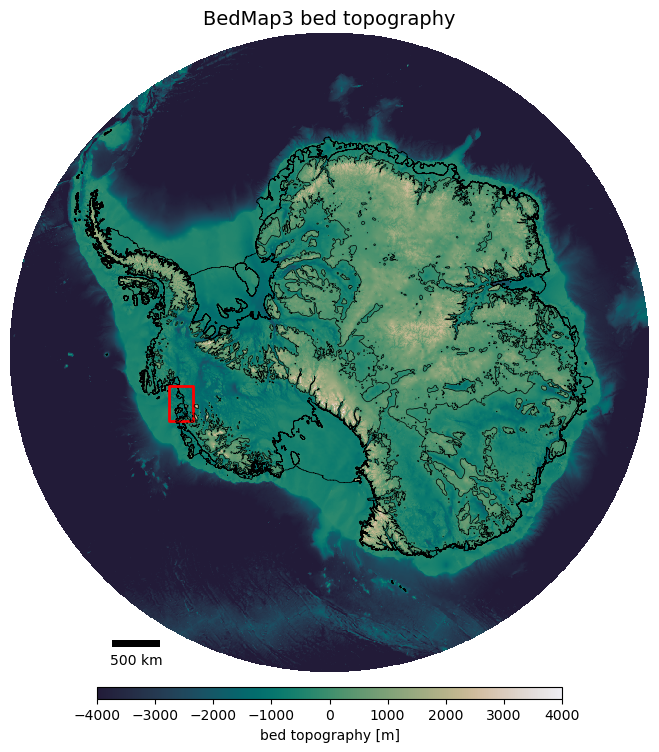

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
im = ax.pcolormesh(bm3.x/1000, bm3.y/1000, bm3.bed_topography, vmin=-4000, vmax=4000, cmap='cmo.rain_r')
ax.contour(bm3.x/1000, bm3.y/1000, bm3.bed_topography, levels=[0], colors=['k'], linewidths=[0.5])
ax.axis('scaled')

glkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)
coastkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)
islandkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.5)

ax.set_title('BedMap3 bed topography', fontsize=14)

cbar = plt.colorbar(im, ax=ax, pad=0.02, aspect=40, shrink=0.5, orientation='horizontal', location='bottom')
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='bed topography [m]', fontsize=10)

scalebar = ScaleBar(1, "km", length_fraction=0.1, location='lower left', bbox_to_anchor=(0.15, 0.00),
    bbox_transform=ax.transAxes)
ax.add_artist(scalebar)

rect = Rectangle((xminkm, yminkm), xmaxkm-xminkm, ymaxkm-yminkm)
collection = PatchCollection([rect], edgecolor='r', facecolor='none', linewidth=2)
ax.add_collection(collection)

ax.set_axis_off()
plt.savefig('bedmap3.png', dpi=300, bbox_inches='tight')
plt.show()

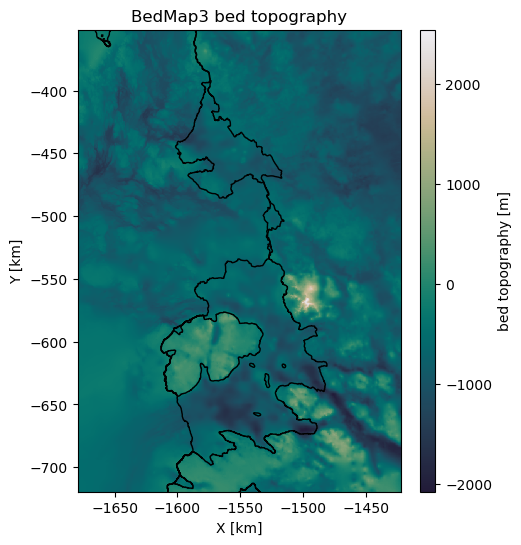

In [35]:
vmin = np.min(bm3_trim.bed_topography.values)
vmax = np.max(bm3_trim.bed_topography.values)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
im = ax.pcolormesh(bm3_trim.x/1000, bm3_trim.y/1000, bm3_trim.bed_topography, vmin=vmin, vmax=vmax, cmap='cmo.rain_r')
ax.axis('scaled')

glkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=1)
coastkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=1)
islandkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=1)

ax.set_title('BedMap3 bed topography')
ax.set_ylabel('Y [km]')
ax.set_xlabel('X [km]')

plt.colorbar(im, ax=ax, pad=0.04, aspect=30, label='bed topography [m]')
plt.savefig('bedmap3_local.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
topo_cmap = get_topo_cm()
vmin_topo = np.nanmin(bm.bed.values); vmax_topo = np.nanmax(bm.bed.values)
topo_crop = cmocean.tools.crop(topo_cmap, vmin_topo, vmax_topo, 0)

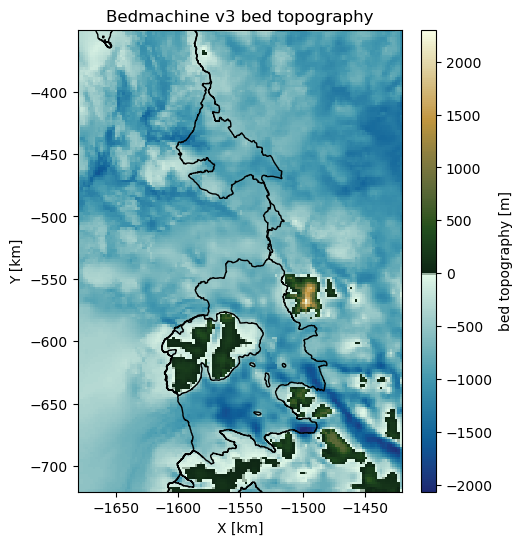

In [37]:
vmin = np.min(bm3_trim.bed_topography.values)
vmax = np.max(bm3_trim.bed_topography.values)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
im = ax.pcolormesh(bm.x/1000, bm.y/1000, bm.bed, vmin=vmin_topo, vmax=vmax_topo, cmap=topo_crop)
ax.axis('scaled')

glkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=1)
coastkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=1)
islandkm.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=1)

ax.set_title('Bedmachine v3 bed topography')
ax.set_ylabel('Y [km]')
ax.set_xlabel('X [km]')

plt.colorbar(im, ax=ax, pad=0.04, aspect=30, label='bed topography [m]')
plt.savefig('bedmachine_local.png', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
ant_basins = gpd.read_file(Path(r'C:\Users\mjfie\Desktop\Inbox\ANT_Basins_IMBIE2_v1.6\ANT_Basins_IMBIE2_v1.6.shp'))

In [39]:
ant_basins

Regions Subregion                                           geometry
0     Islands      None  MULTIPOLYGON (((2404549.605 -824175.129, 24052...
1        West      H-Hp  POLYGON ((-1747055.814 -7497.327, -1749638.686...
2        West       F-G  POLYGON ((-914638.723 -1276047.57, -914860.999...
3        East      E-Ep  POLYGON ((-239862.18 -442192.806, -242322.167 ...
4        East      D-Dp  POLYGON ((1453579.447 -2047575.392, 1453837.89...
5        East      Cp-D  POLYGON ((2317315.872 -603916.511, 2321147.611...
6        East       B-C  POLYGON ((966968.15 243373.335, 947620.405 249...
7        East      A-Ap  POLYGON ((-184951.916 1856588.117, -190292.664...
8        East     Jpp-K  POLYGON ((-650545.636 590416.431, -649059.659 ...
9        West       G-H  POLYGON ((-1845325.049 -419925.255, -1839452.1...
10       East      Dp-E  POLYGON ((393072.24 -1759690.414, 393493.61 -1...
11       East      Ap-B  POLYGON ((1367928.932 1754234.348, 1371056.345...
12       East      C-Cp  POLYGON ((2590357.173 -594864.572, 2590343.457...
13       East       K-A  POLYGON ((-378324.562 2048575.36, -377700.182 ...
14       West     J-Jpp  POLYGON ((-1598551.263 753182.41, -1596315.131...
15  Peninsula     Ipp-J  POLYGON ((-1980985.266 931298.681, -1981820.60...
16  Peninsula     I-Ipp  POLYGON ((-2111011.44 1081009.311, -2109656.61...
17  Peninsula      Hp-I  POLYGON ((-2108546.259 816149.073, -2109074.79...
18       West      Ep-F  POLYGON ((-507963.49 -1079550.029, -505533.531...

In [40]:
ant_basinskm = ant_basins.to_crs('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs +type=crs')

In [41]:
grid = bm3.sel(x=slice(-2.85e6, 2.85e6), y=slice(2.35e6, -2.2e6))

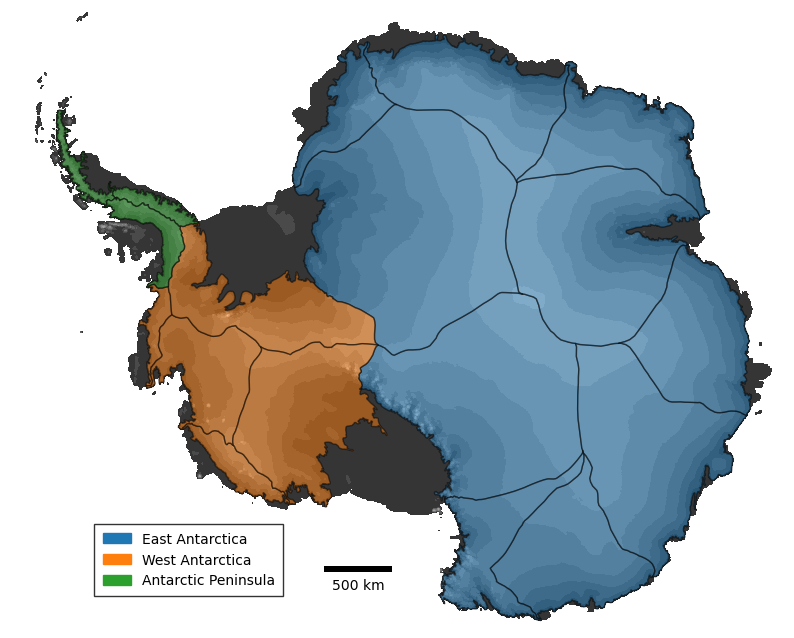

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.contourf(grid.x/1000, grid.y/1000, grid.surface_topography, levels=10, cmap='gray', vmin=-1000)

ant_basinskm[ant_basinskm.Regions=='East'].plot(facecolor='tab:blue', edgecolor='k', ax=ax, linewidth=1, alpha=0.5)
ant_basinskm[ant_basinskm.Regions=='West'].plot(facecolor='tab:orange', edgecolor='k', ax=ax, linewidth=1, alpha=0.5)
ant_basinskm[ant_basinskm.Regions=='Peninsula'].plot(facecolor='tab:green', edgecolor='k', ax=ax, linewidth=1, alpha=0.5)

scalebar = ScaleBar(1, "km", length_fraction=0.1, location='lower left', bbox_to_anchor=(0.4, 0.05),
    bbox_transform=ax.transAxes)
ax.add_artist(scalebar)

blue_patch = mpatches.Patch(color='tab:blue', label='East Antarctica')
orange_patch = mpatches.Patch(color='tab:orange', label='West Antarctica')
green_patch = mpatches.Patch(color='tab:green', label='Antarctic Peninsula')
ax.legend(handles=[blue_patch, orange_patch, green_patch], loc='lower left', bbox_to_anchor=(0.1, 0.04),
    bbox_transform=ax.transAxes, edgecolor='k', fancybox=False, borderpad=0.6)

ax.set_axis_off()
plt.savefig('basins_east_west.png', dpi=300, bbox_inches='tight')
plt.show()

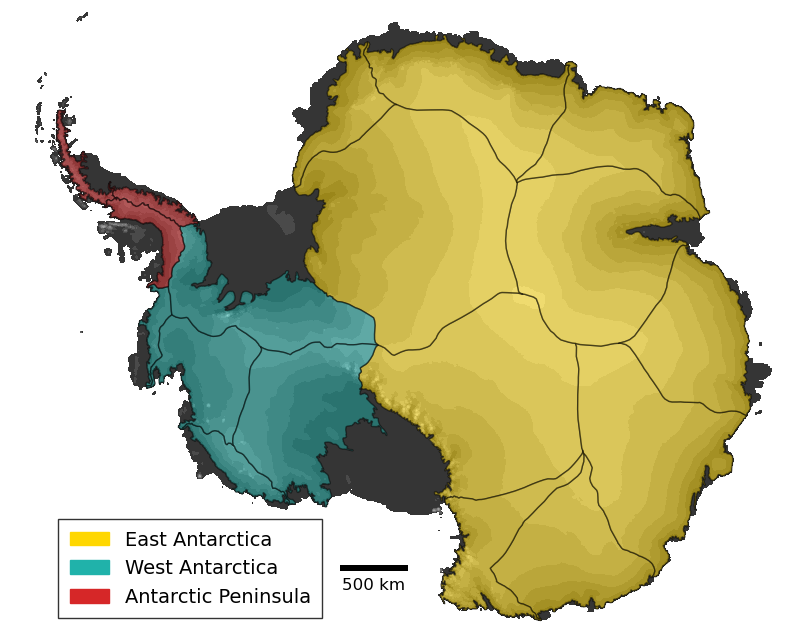

In [43]:
east_color = 'gold'
west_color = 'lightseagreen'
peninsula_color = 'tab:red'

fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.contourf(grid.x/1000, grid.y/1000, grid.surface_topography, levels=10, cmap='gray', vmin=-1000)

ant_basinskm[ant_basinskm.Regions=='East'].plot(facecolor=east_color, edgecolor='k', ax=ax, linewidth=1, alpha=0.5)
ant_basinskm[ant_basinskm.Regions=='West'].plot(facecolor=west_color, edgecolor='k', ax=ax, linewidth=1, alpha=0.5)
ant_basinskm[ant_basinskm.Regions=='Peninsula'].plot(facecolor=peninsula_color, edgecolor='k', ax=ax, linewidth=1, alpha=0.5)

scalebar = ScaleBar(1, "km", length_fraction=0.1, location='lower left', bbox_to_anchor=(0.42, 0.05),
    bbox_transform=ax.transAxes, font_properties=dict(size=12))
ax.add_artist(scalebar)

blue_patch = mpatches.Patch(color=east_color, label='East Antarctica')
orange_patch = mpatches.Patch(color=west_color, label='West Antarctica')
green_patch = mpatches.Patch(color=peninsula_color, label='Antarctic Peninsula')
ax.legend(handles=[blue_patch, orange_patch, green_patch], loc='lower left', bbox_to_anchor=(0.05, 0.00),
    bbox_transform=ax.transAxes, edgecolor='k', fancybox=False, borderpad=0.6, fontsize=14)

ax.set_axis_off()
plt.savefig('basins_east_west.png', dpi=300, bbox_inches='tight')
plt.show()